In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.optimizers import Adam

img_height, img_width = 300, 300

# Custom focal loss definition (if used in the model)
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        return alpha * (1 - pt) ** gamma * bce
    return loss

# Load the trained model
model = load_model('./Custom Model/section_2_clear.h5', custom_objects={'loss': focal_loss()})

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=focal_loss(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

def predict_single_image(image_path, model):
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Image not found or cannot be loaded: {image_path}")
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        img = cv2.resize(img, (img_height, img_width))  # Resize to model input size
        img = img / 255.0  # Normalize pixel values to [0, 1]
        img = tf.expand_dims(img, axis=0)  # Add batch dimension

        # Predict using the loaded model
        prediction = model.predict(img, verbose=0)  # Suppress verbose output
        predicted_class = (prediction > 0.5).astype(int)  # Binary class prediction
        probability = prediction[0][0]

        print(f"Predicted Class: {predicted_class[0]}, Probability: {probability:.2f}")
        return predicted_class[0], probability
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None, None

# Example usage
predict_single_image('./Clear Section 2/train/class 0/bad_m_275.png', model)

Predicted Class: [1], Probability: 1.00


(array([1]), 1.0)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to the images
master_image_path = "./clear_section.png"
captured_image_path = "./Analog_mobile/test/class 0/bad_m_46.png"

# Load images in grayscale
master_image = cv2.imread(master_image_path, cv2.IMREAD_GRAYSCALE)
captured_image = cv2.imread(captured_image_path, cv2.IMREAD_GRAYSCALE)

# Resize captured image to match master image dimensions
captured_image = cv2.resize(captured_image, (master_image.shape[1], master_image.shape[0]))

# --- Step 1: Adaptive Thresholding for Consistent Segmentation ---
master_thresh = cv2.adaptiveThreshold(master_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
captured_thresh = cv2.adaptiveThreshold(captured_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# --- Step 2: Find Contours ---
master_contours, _ = cv2.findContours(master_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
captured_contours, _ = cv2.findContours(captured_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# --- Step 3: Compare Contours ---
missing_segments = []

for master_contour in master_contours:
    match_found = False
    
    # Only consider contours of similar area
    master_area = cv2.contourArea(master_contour)
    
    for captured_contour in captured_contours:
        captured_area = cv2.contourArea(captured_contour)
        
        # Check for approximate area match (within a tolerance range)
        if abs(master_area - captured_area) < 500:  # Adjust tolerance as needed
            # Compare contour shapes using matchShapes
            shape_diff = cv2.matchShapes(master_contour, captured_contour, cv2.CONTOURS_MATCH_I1, 0.0)
            if shape_diff < 0.05:  # Threshold for shape similarity, adjust as needed
                match_found = True
                break
    
    if not match_found:
        missing_segments.append(master_contour)

# --- Step 4: Highlight Missing Segments ---
output_image = cv2.cvtColor(master_image, cv2.COLOR_GRAY2BGR)
for segment in missing_segments:
    cv2.drawContours(output_image, [segment], -1, (0, 0, 255), 2)  # Highlight in red

# --- Step 5: Visualize Results ---
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.title("Master Image (Thresholded)")
plt.imshow(master_thresh, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Captured Image (Thresholded)")
plt.imshow(captured_thresh, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Missing Segments Highlighted")
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

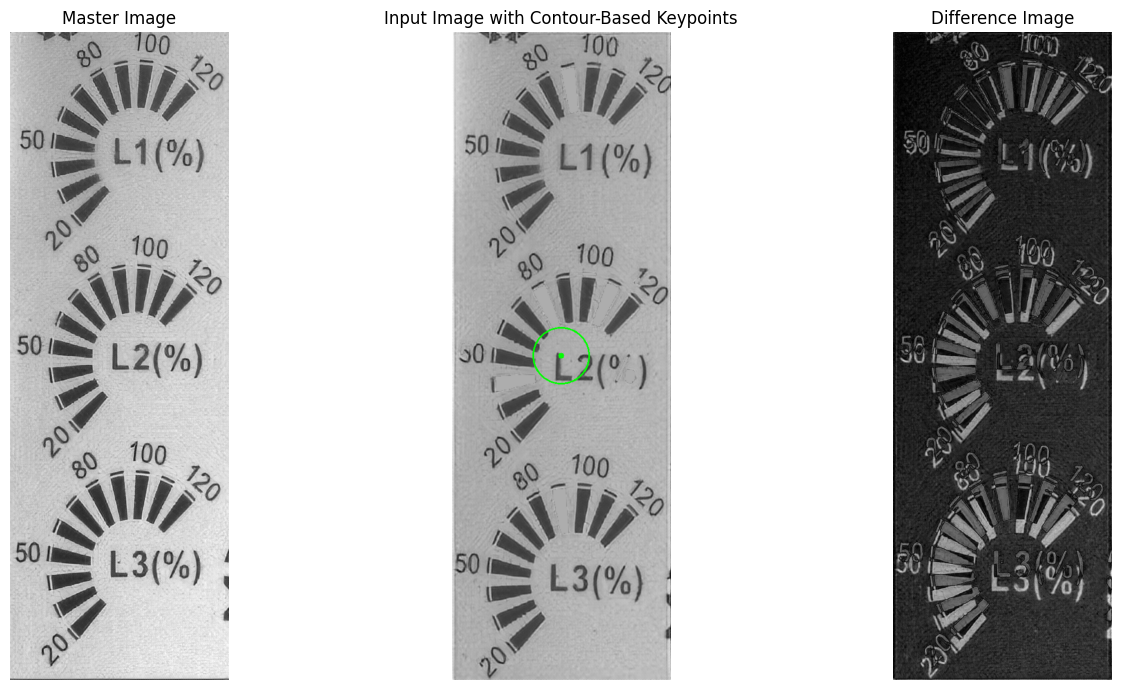

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to the images
master_image_path = "./clear_section.png"
input_image_path = "./Analog_mobile/test/class 0/bad_m_46.png"

# Load images
master_image = cv2.imread(master_image_path, cv2.IMREAD_GRAYSCALE)
input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# Resize input image to match master image dimensions
input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))

# Function to extract contour centroids
def get_contour_centroids(image, threshold=50):
    # Threshold the image to get binary
    _, binary = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    # Detect contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Calculate centroids of contours
    centroids = []
    for contour in contours:
        if cv2.contourArea(contour) < 10:  # Filter out small contours
            continue
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append((cx, cy))
    return centroids

# Extract centroids from master and input images
master_centroids = get_contour_centroids(master_image)
input_centroids = get_contour_centroids(input_image)

# Match centroids based on distance
radius = 50  # Define the matching radius
matched = []
unmatched = input_centroids.copy()

for input_pt in input_centroids:
    for master_pt in master_centroids:
        distance = np.linalg.norm(np.array(input_pt) - np.array(master_pt))
        if distance <= radius:
            matched.append(input_pt)
            if input_pt in unmatched:
                unmatched.remove(input_pt)
            break

# Create output image
output_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)

# Mark matched centroids in green
for pt in matched:
    cv2.circle(output_image, pt, radius, (0, 255, 0), 2)  # Green circle
    cv2.circle(output_image, pt, 5, (0, 255, 0), -1)  # Green center

# Mark unmatched centroids in red
for pt in unmatched:
    cv2.circle(output_image, pt, radius, (0, 0, 255), 2)  # Red circle
    cv2.circle(output_image, pt, 5, (0, 0, 255), -1)  # Red center

# Display results
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.title("Master Image")
plt.imshow(master_image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Input Image with Contour-Based Keypoints")
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Optional: Display differences
difference_image = cv2.absdiff(master_image, input_image)
plt.subplot(1, 3, 3)
plt.title("Difference Image")
plt.imshow(difference_image, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np

# Function to dynamically select the threshold value
def select_threshold(image):
    def update_threshold(val):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Use the morphed image for thresholding and contour detection
        _, binary = cv2.threshold(gray, val, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_image = image.copy()
        for contour in contours:
            if cv2.contourArea(contour) > 10:
                cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)
        cv2.imshow("Select Threshold", contour_image)

    cv2.namedWindow("Select Threshold", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Select Threshold", 500, 800)
    cv2.createTrackbar("Threshold", "Select Threshold", 128, 255, update_threshold)
    update_threshold(128)
    cv2.waitKey(0)
    threshold_value = cv2.getTrackbarPos("Threshold", "Select Threshold")
    cv2.destroyAllWindows()
    return threshold_value

# Function to interactively select contours based on mouse clicks
def select_contours(image, contours):
    selected_contours = []

    def on_mouse_click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            for contour in contours:
                if cv2.pointPolygonTest(contour, (x, y), False) >= 0:  # Check if point is inside contour
                    selected_contours.append(contour)
                    # Draw the contour to indicate selection
                    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
                    print("Contour selected!")
            cv2.imshow("Select Contours", image)

    # Show the image and wait for user input
    cv2.imshow("Select Contours", image)
    cv2.setMouseCallback("Select Contours", on_mouse_click)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return selected_contours

# Function to filter keypoints inside selected contours
def filter_keypoints_by_contours(keypoints, selected_contours):
    filtered_keypoints = []
    for kp in keypoints:
        x, y = kp.pt
        for contour in selected_contours:
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:  # Keypoint inside the contour
                filtered_keypoints.append(kp)
    return filtered_keypoints

# Load the image
image_path = "./clear_section.png"
image = cv2.imread(image_path)

# Select the threshold value dynamically
threshold_value = select_threshold(image)

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use the morphed image for thresholding and contour detection
_, binary = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the detected contours on the original image
contour_image = image.copy()
for contour in contours:
    if cv2.contourArea(contour) > 10:  # Filter out small contours
        cv2.drawContours(contour_image, [contour], -1, (0, 255, 0), 2)

# Select contours interactively from the image
selected_contours = [contour for contour in contours if cv2.contourArea(contour) > 10]
# Now detect keypoints using ORB
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(image, None)

# Filter keypoints based on the selected contours
filtered_keypoints = filter_keypoints_by_contours(keypoints, selected_contours)

# Draw the filtered keypoints on the image
image_with_keypoints = image.copy()
cv2.drawKeypoints(image_with_keypoints, filtered_keypoints, image_with_keypoints, color=(0, 0, 255), flags=0)

# Show the result with selected contours and keypoints
cv2.imshow("Selected Keypoints", image_with_keypoints)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Optionally, save the keypoints and descriptors inside the selected contours
filtered_descriptors = [descriptors[i] for i, kp in enumerate(keypoints) if kp in filtered_keypoints]


print(f"Number of selected keypoints: {len(filtered_keypoints)}")

Number of selected keypoints: 447


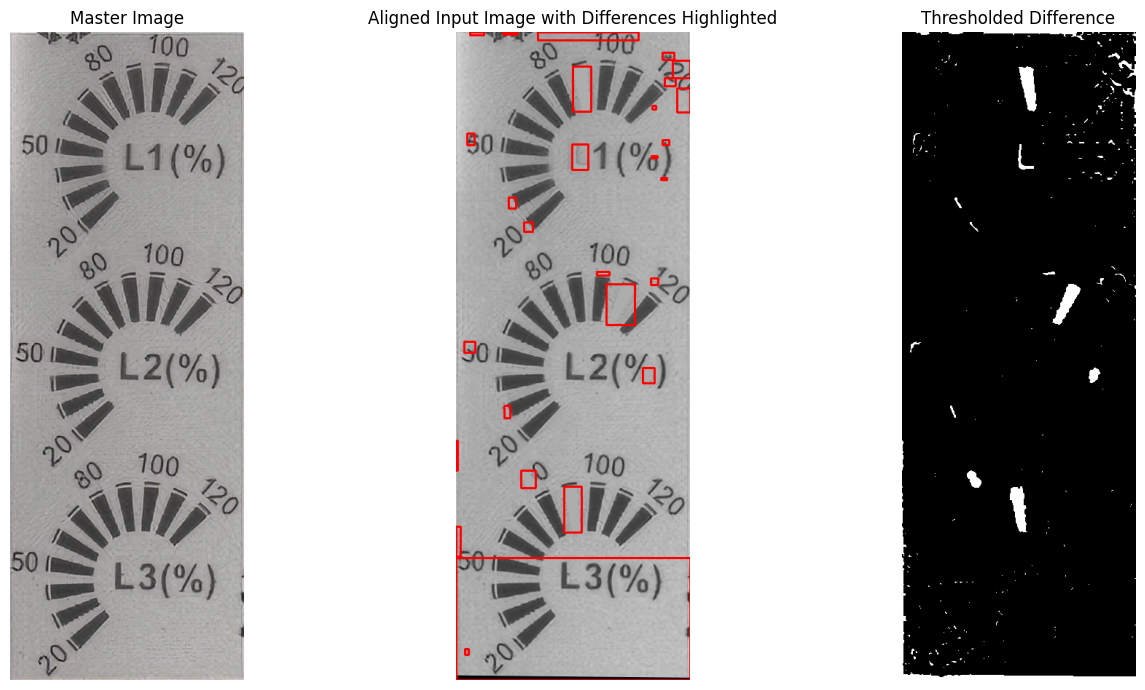

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to preprocess images (e.g., denoise, adjust contrast)
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply histogram equalization to improve contrast
    equalized = cv2.equalizeHist(blurred)
    
    return equalized

# Function to align the input image to the master image
def align_images(master, input_img):
    master_preprocessed = preprocess_image(master)
    input_preprocessed = preprocess_image(input_img)
    
    # Detect and describe features using ORB
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(master_preprocessed, None)
    keypoints2, descriptors2 = orb.detectAndCompute(input_preprocessed, None)
    
    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Compute the homography matrix
    h_matrix, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)
    
    # Align the input image
    aligned_img = cv2.warpPerspective(input_img, h_matrix, (master.shape[1], master.shape[0]))
    return aligned_img

# Load images
master_image_path = "./Analog_mobile/test/class 1/good_243.png"
input_image_path = "./Analog_mobile/test/class 0/bad_m_88.png"

master_image = cv2.imread(master_image_path)
input_image = cv2.imread(input_image_path)

input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))

# Align the input image to the master image
aligned_input_img = align_images(master_image, input_image)

# Preprocess both images for comparison
aligned_master_gray = preprocess_image(master_image)
aligned_input_gray = preprocess_image(aligned_input_img)

# Compute the absolute difference
difference = cv2.absdiff(aligned_master_gray, aligned_input_gray)

cv2.imwrite('difference.png', difference)

_, thresholded_diff = cv2.threshold(difference, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Optional: Morphological operation to clean small noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresholded_diff = cv2.morphologyEx(thresholded_diff, cv2.MORPH_CLOSE, kernel)

# Find contours of differences
contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Highlight differences on the aligned input image
highlighted_image = aligned_input_img.copy()
for contour in contours:
    if cv2.contourArea(contour) > 10 and cv2.contourArea(contour) < 2000:  # Filter small differences
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(highlighted_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Display results
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.title("Master Image")
plt.imshow(cv2.cvtColor(master_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Aligned Input Image with Differences Highlighted")
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Thresholded Difference")
plt.imshow(thresholded_diff, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

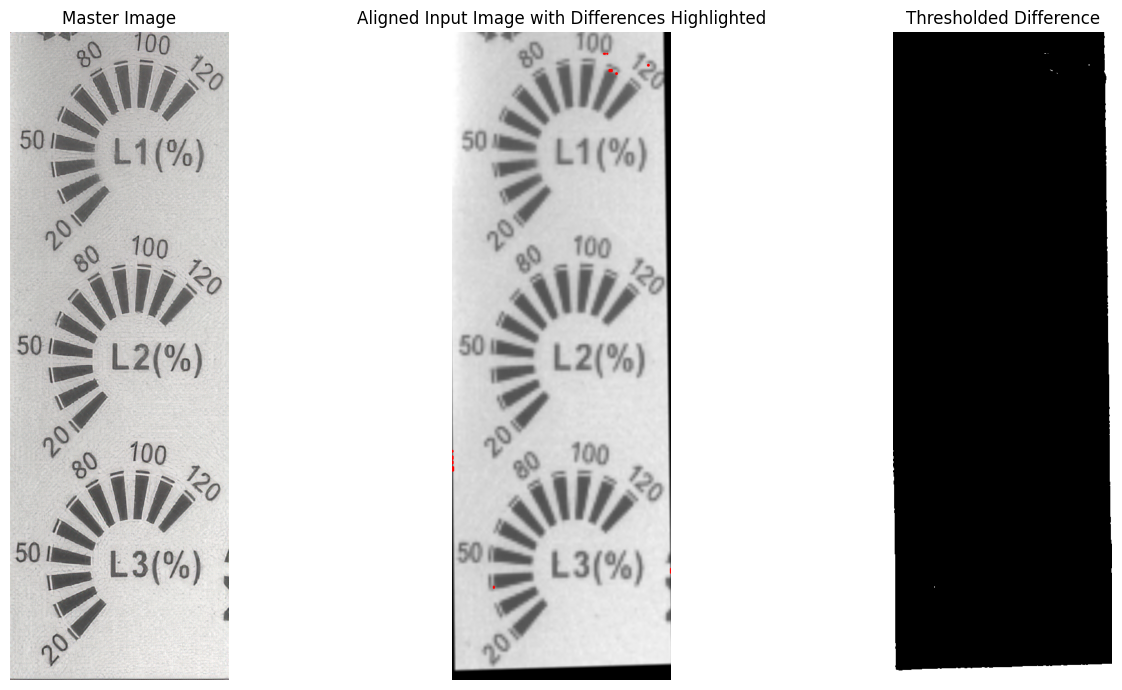

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to preprocess images
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(blurred)
    return equalized

# Function to align the input image to the master image
def align_images(master, input_img):
    # Preprocess both images
    master_preprocessed = preprocess_image(master)
    input_preprocessed = preprocess_image(input_img)
    
    # Use SIFT for feature detection and description
    sift = cv2.SIFT_create(nfeatures=5000)  # Increased number of features
    keypoints1, descriptors1 = sift.detectAndCompute(master_preprocessed, None)
    keypoints2, descriptors2 = sift.detectAndCompute(input_preprocessed, None)
    
    # Match features using FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.6 * n.distance]
    
    # Ensure we have enough matches to compute homography
    if len(good_matches) < 4:
        raise ValueError("Not enough matches found to compute homography. Alignment failed.")
    
    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Compute the homography matrix
    h_matrix, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)
    
    # Align the input image
    aligned_img = cv2.warpPerspective(input_img, h_matrix, (master.shape[1], master.shape[0]))
    return aligned_img, h_matrix

# Load images
master_image_path = "./clear_section.png"
input_image_path = "./Analog/test/class 1/good_4.png"

master_image = cv2.imread(master_image_path)
input_image = cv2.imread(input_image_path)

# Resize input image to match the size of the master image
input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))

# Align the input image to the master image
aligned_input_img, h_matrix = align_images(master_image, input_image)

# Preprocess both images for comparison
aligned_master_gray = preprocess_image(master_image)
aligned_input_gray = preprocess_image(aligned_input_img)

# Compute the absolute difference
difference = cv2.absdiff(aligned_master_gray, aligned_input_gray)

# Save the difference image
cv2.imwrite('difference.png', difference)

# Threshold the difference image
_, thresholded_diff = cv2.threshold(difference, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply morphological operations to remove small noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresholded_diff = cv2.morphologyEx(thresholded_diff, cv2.MORPH_CLOSE, kernel)

# Find contours of differences
contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Highlight differences on the aligned input image
highlighted_image = aligned_input_img.copy()
for contour in contours:
    if cv2.contourArea(contour) < 2000:  # Filter small and excessively large differences
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(highlighted_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Display results
plt.figure(figsize=(15, 7))
plt.subplot(1, 3, 1)
plt.title("Master Image")
plt.imshow(cv2.cvtColor(master_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Aligned Input Image with Differences Highlighted")
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Thresholded Difference")
plt.imshow(thresholded_diff, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

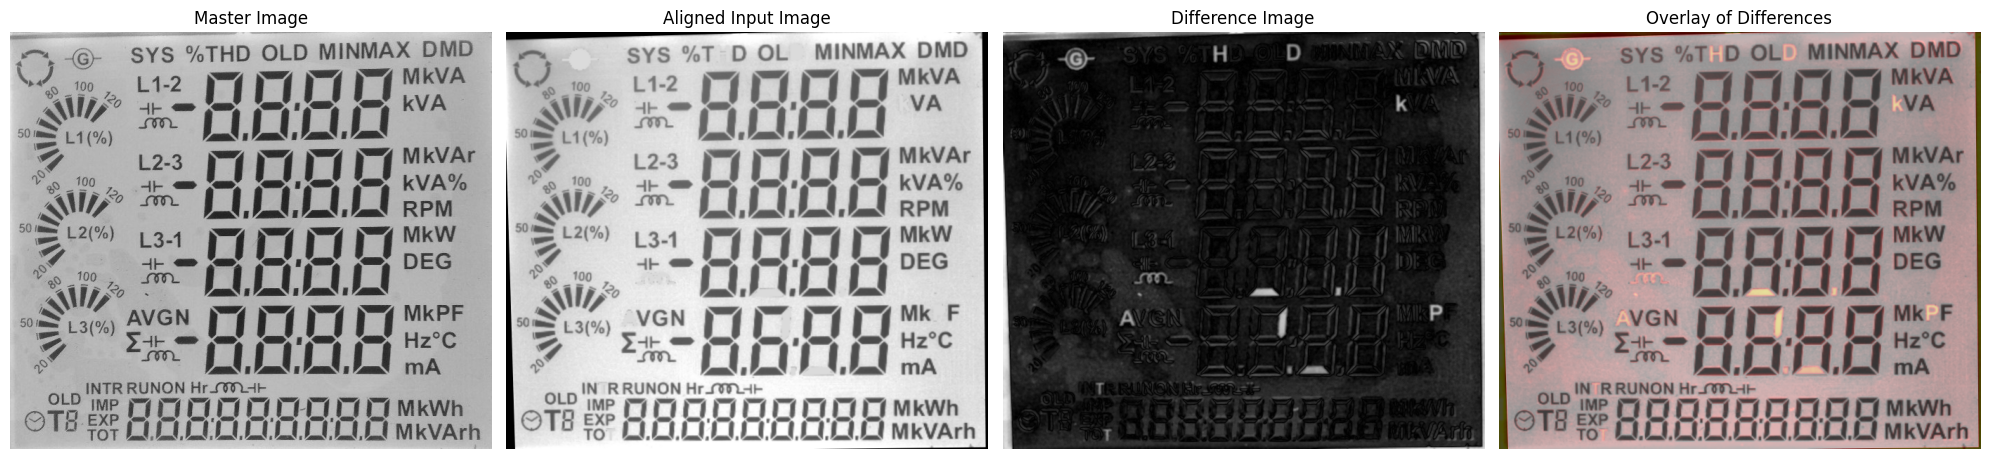

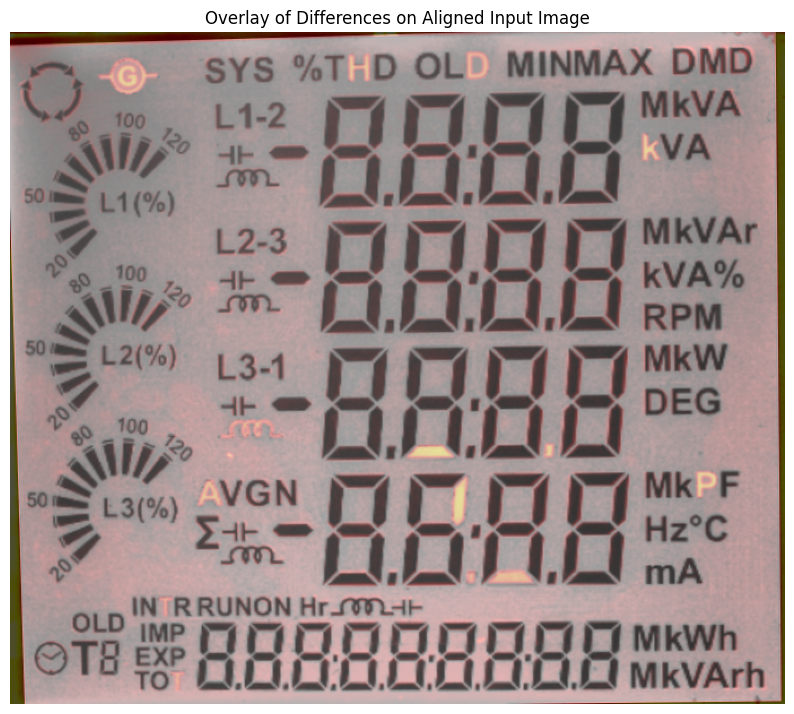

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to preprocess images
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(blurred)
    return equalized

# Function to align the input image to the master image
def align_images(master, input_img):
    # Preprocess both images
    master_preprocessed = preprocess_image(master)
    input_preprocessed = preprocess_image(input_img)
    
    # Use SIFT for feature detection and description
    sift = cv2.SIFT_create(nfeatures=5000)  # Increased number of features
    keypoints1, descriptors1 = sift.detectAndCompute(master_preprocessed, None)
    keypoints2, descriptors2 = sift.detectAndCompute(input_preprocessed, None)
    
    # Match features using FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.6 * n.distance]
    
    # Ensure we have enough matches to compute homography
    if len(good_matches) < 4:
        raise ValueError("Not enough matches found to compute homography. Alignment failed.")
    
    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Compute the homography matrix
    h_matrix, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)
    
    # Align the input image
    aligned_img = cv2.warpPerspective(input_img, h_matrix, (master.shape[1], master.shape[0]))
    return aligned_img, h_matrix

# Load images
master_image_path = "./Meter.jpg"
input_image_path = "./Digit extraction/full_1.png"

master_image = cv2.imread(master_image_path)
input_image = cv2.imread(input_image_path)

# Resize input image to match the size of the master image
input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))

# Align the input image to the master image
aligned_input_img, h_matrix = align_images(master_image, input_image)

# Preprocess both images for comparison
aligned_master_gray = preprocess_image(master_image)
aligned_input_gray = preprocess_image(aligned_input_img)

# Compute the absolute difference
difference = cv2.absdiff(aligned_master_gray, aligned_input_gray)

# Save the difference image
cv2.imwrite('difference.png', difference)

# Threshold the difference image
_, thresholded_diff = cv2.threshold(difference, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply morphological operations to remove small noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresholded_diff = cv2.morphologyEx(thresholded_diff, cv2.MORPH_CLOSE, kernel)

# Find contours of differences
contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Highlight differences on the aligned input image
highlighted_image = aligned_input_img.copy()
for contour in contours:
    if cv2.contourArea(contour) < 2000:  # Filter small and excessively large differences
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(highlighted_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Normalize the difference image for better visualization
normalized_diff = cv2.normalize(difference, None, 0, 255, cv2.NORM_MINMAX)

# Convert the normalized difference image to a color image using a bright colormap
colored_diff = cv2.applyColorMap(normalized_diff, cv2.COLORMAP_HOT)

# Overlay the colored difference image on the aligned input image
overlay = cv2.addWeighted(aligned_input_img, 0.7, colored_diff, 0.3, 0)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.title("Master Image")
plt.imshow(cv2.cvtColor(master_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Aligned Input Image")
plt.imshow(cv2.cvtColor(aligned_input_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Difference Image")
plt.imshow(difference, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("Overlay of Differences")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

# Display highlighted differences
plt.figure(figsize=(10, 10))
plt.title("Overlay of Differences on Aligned Input Image")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## New Version Canny Edge Detection

SSIM: 0.9782
MSE: 1.4524
Keypoint Reprojection Error: 1.1053


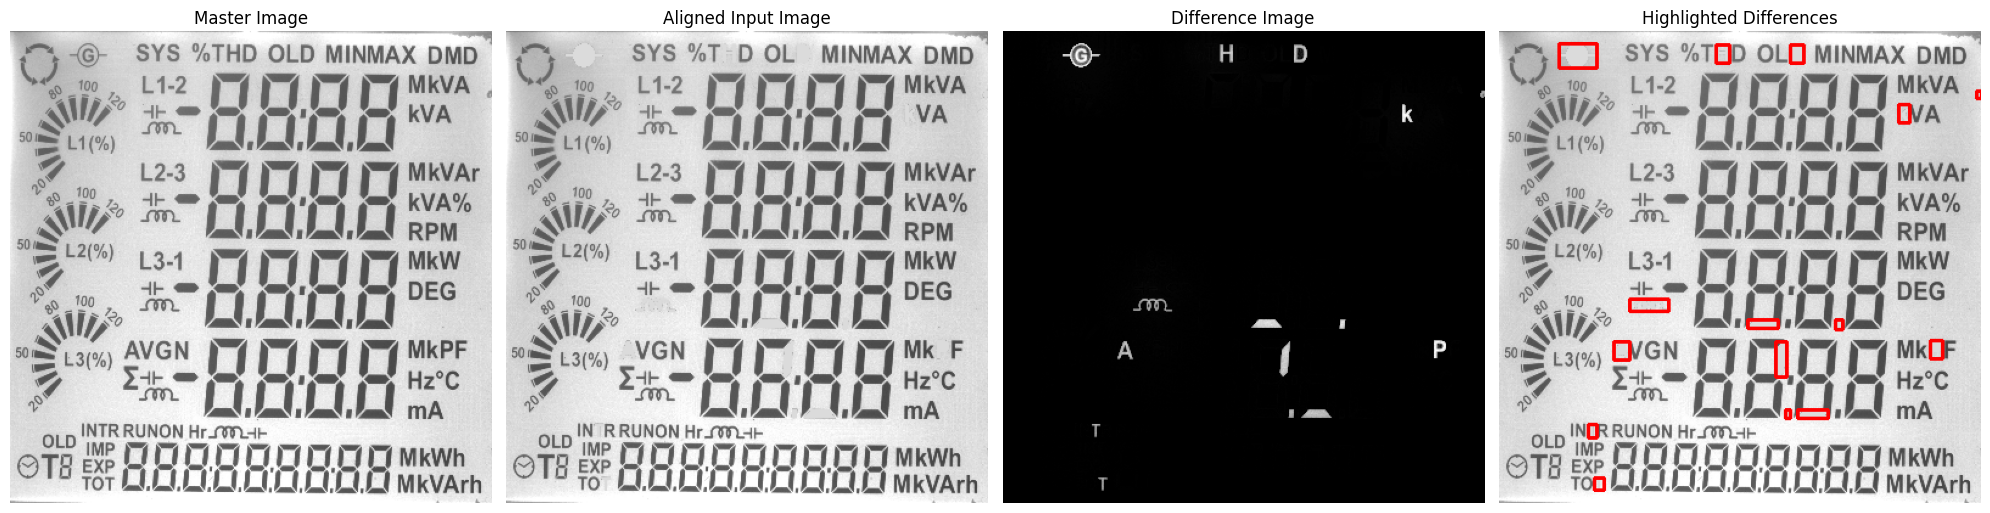

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim

# Function to preprocess images (e.g., denoise, adjust contrast)
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to reduce noise
    """ blurred = cv2.GaussianBlur(gray, (5, 5), 0) """
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to improve local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    return equalized

# Function to align the input image to the master image
def align_images(master, input_img):
    master_preprocessed = preprocess_image(master)
    input_preprocessed = preprocess_image(input_img)
    
    # Detect and describe features using SIFT
    sift = cv2.SIFT_create(nfeatures=8000)
    keypoints1, descriptors1 = sift.detectAndCompute(master_preprocessed, None)
    keypoints2, descriptors2 = sift.detectAndCompute(input_preprocessed, None)
    
    # Match features using FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test to filter good matches
    good_matches = [m for m, n in matches if m.distance < 0.5 * n.distance]
    
    # Ensure we have enough matches to compute homography
    if len(good_matches) < 4:
        raise ValueError("Not enough matches found to compute homography. Alignment failed.")
    
    # Extract matched points
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Compute the homography matrix
    h_matrix, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)
    
    # Align the input image
    aligned_img = cv2.warpPerspective(input_img, h_matrix, (master.shape[1], master.shape[0]))
    return aligned_img, h_matrix, points1, points2

# Function to compute alignment metrics
def compute_alignment_metrics(master, aligned_input, h_matrix, points1, points2):
    # Compute SSIM
    ssim_score, _ = compare_ssim(master, aligned_input, full=True)
    
    # Compute MSE
    mse = np.mean((master - aligned_input) ** 2)
    
    # Compute Keypoint Reprojection Error
    points2_transformed = cv2.perspectiveTransform(points2, h_matrix)
    reprojection_error = np.mean(np.linalg.norm(points2_transformed - points1, axis=2))
    
    return ssim_score, mse, reprojection_error

# Load images
master_image_path = "./section 2 clear/New_Master.png"
input_image_path = "./Digit extraction/full_1.png"

master_image = cv2.imread(master_image_path)
input_image = cv2.imread(input_image_path)

# Resize input image to match the size of the master image
input_image = cv2.resize(input_image, (master_image.shape[1], master_image.shape[0]))

# Align the input image to the master image
aligned_input_img, h_matrix, points1, points2 = align_images(master_image, input_image)

# Preprocess both images for comparison
aligned_master_gray = preprocess_image(master_image)
aligned_input_gray = preprocess_image(aligned_input_img)

# Compute alignment metrics
ssim_score, mse, reprojection_error = compute_alignment_metrics(aligned_master_gray, aligned_input_gray, h_matrix, points1, points2)

# Print alignment metrics
print(f"SSIM: {ssim_score:.4f}")
print(f"MSE: {mse:.4f}")
print(f"Keypoint Reprojection Error: {reprojection_error:.4f}")

# Compute the absolute difference
difference = cv2.absdiff(aligned_master_gray, aligned_input_gray)

# Save the difference image
cv2.imwrite('difference.png', difference)

# Apply Otsu's thresholding to the difference image
thresholded_diff = cv2.threshold(difference, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Apply morphological operations to remove small noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thresholded_diff = cv2.morphologyEx(thresholded_diff, cv2.MORPH_CLOSE, kernel)

cv2.imwrite("Thresholded Diff.png", thresholded_diff)

# Find contours of differences
contours, _ = cv2.findContours(thresholded_diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Highlight differences on the aligned input image
highlighted_image = aligned_input_img.copy()
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(highlighted_image, (x, y), (x + w, y + h), (0, 0, 255), 2)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.title("Master Image")
plt.imshow(cv2.cvtColor(master_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Aligned Input Image")
plt.imshow(cv2.cvtColor(aligned_input_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Difference Image")
plt.imshow(difference, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("Highlighted Differences")
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()